In [5]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

warnings.filterwarnings("ignore")

In [7]:
!unzip "../content/drive/MyDrive/train.zip" -d "../content/sample_data"

Streaming output truncated to the last 5000 lines.
  inflating: ../content/sample_data/train/audio/five/cd3331a6_nohash_2.wav  
  inflating: ../content/sample_data/train/audio/five/460f2bad_nohash_0.wav  
  inflating: ../content/sample_data/train/audio/five/4c7c95de_nohash_1.wav  
  inflating: ../content/sample_data/train/audio/five/ed3e20dc_nohash_0.wav  
  inflating: ../content/sample_data/train/audio/five/190821dc_nohash_4.wav  
  inflating: ../content/sample_data/train/audio/five/099d52ad_nohash_1.wav  
  inflating: ../content/sample_data/train/audio/five/51995cea_nohash_0.wav  
  inflating: ../content/sample_data/train/audio/five/9712cce0_nohash_0.wav  
  inflating: ../content/sample_data/train/audio/five/6aafb34f_nohash_0.wav  
  inflating: ../content/sample_data/train/audio/five/106a6183_nohash_4.wav  
  inflating: ../content/sample_data/train/audio/five/cb2929ce_nohash_3.wav  
  inflating: ../content/sample_data/train/audio/five/95ba4996_nohash_0.wav  
  inflating: ../content/s

**Data Visualization**

16000
16000


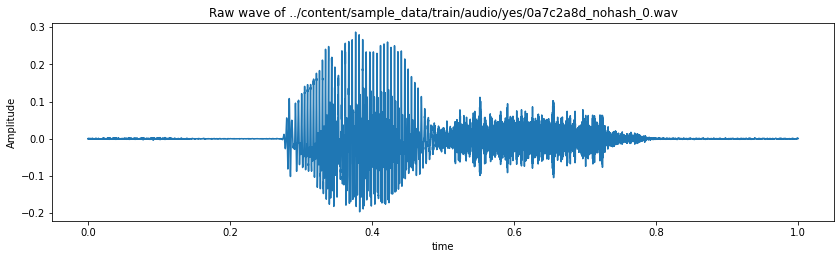

In [18]:
train_audio_path = '../content/sample_data/train/audio'
samples, sample_rate = librosa.load('../content/sample_data/train/audio/yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../content/sample_data/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

print(len(samples))
print(sample_rate)
# 4 5 5
# 4 4.25 4.5 4.75 5

In [9]:
ipd.Audio(samples, rate=sample_rate)

In [10]:
print(sample_rate)

16000


**Resampling**

From the above, we can understand that the sampling rate of the signal is 16000 hz. Let us resample it to 8000 hz since most of the speech related frequencies are present in 8000 hz 

In [11]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [7]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

In [8]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

NameError: ignored

In [47]:
print(sum(no_of_recordings))

23682


**Duration of recordings**


(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

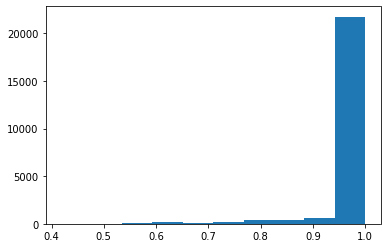

In [15]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

**Preprocessing of the audio waves**

* Resampling
* Remove shorter than 1 sec video


In [44]:
train_audio_path = '../content/sample_data/train/audio'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)



yes
no
up
down
left
right
on
off
stop
go


In [50]:
print(len(all_wave))
print(len(all_wave[0]))

21312
8000


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [21]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [22]:
all_wave = np.array(all_wave).reshape(-1,8000,1)

**Split into train and validation data**



In [6]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

print(len(x_tr))
print(len(x_val))

NameError: ignored

**Model**

In [24]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [25]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

Let us train the model on a batch size of 32 and evaluate the performance

In [27]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - 135s 250ms/step - loss: 2.1616 - accuracy: 0.1794 - val_loss: 1.9668 - val_accuracy: 0.2709
Epoch 2/100
533/533 [==============================] - 132s 249ms/step - loss: 1.5742 - accuracy: 0.4116 - val_loss: 1.2619 - val_accuracy: 0.5327
Epoch 3/100
533/533 [==============================] - 132s 248ms/step - loss: 1.1592 - accuracy: 0.5767 - val_loss: 0.9736 - val_accuracy: 0.6519
Epoch 4/100
533/533 [==============================] - 133s 249ms/step - loss: 0.9788 - accuracy: 0.6540 - val_loss: 0.8620 - val_accuracy: 0.7157
Epoch 5/100
533/533 [==============================] - 135s 253ms/step - loss: 0.8814 - accuracy: 0.6881 - val_loss: 0.7743 - val_accuracy: 0.7417
Epoch 6/100
533/533 [==============================] - 133s 249ms/step - loss: 0.7862 - accuracy: 0.7254 - val_loss: 0.7300 - val_accuracy: 0.7474
Epoch 7/100
533/533 [==============================] - 134s 251ms/step - loss: 0.7330 - accuracy: 0.7436 - val_loss: 0

In [28]:
model.save('best_model.hdf5')

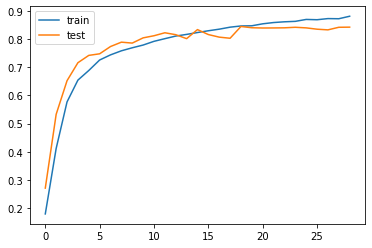

In [29]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

**Loading the best model**

In [1]:
from keras.models import load_model
model=load_model('best_model.hdf5')

In [2]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

Make predictions on the validation data

In [3]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

NameError: ignored

In [33]:
print("Text:",predict(samples))

Text: left
